# Movie Data Set Notebook 2 -- Poster Stuff

In [1]:
# General imports here.
import pandas as pd
import numpy as np
import sklearn as sk
import math
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from matplotlib.pyplot import imshow
%matplotlib inline

In [2]:
# Read the csv files and index appropriately.
keywords_df = pd.read_csv('./data/keywords.csv')
credits_df = pd.read_csv('./data/credits.csv')
metadata_df = pd.read_csv('./data/movies_metadata.csv')

In [3]:
# These three files seem to be the ones we want. Indexed on ID, we could probably combine them now.
keywords_df = keywords_df.set_index('id')
credits_df = credits_df.set_index('id')
metadata_df = metadata_df.set_index('id')
# Join the useful data frames together
temp = keywords_df.join(credits_df)
movie_df = metadata_df.join(temp)

In [4]:
# Here I'm just doing some of the same stuff "The Story of Film" did on Kaggle.
# This all makes sense, it's pretty standard.
movie_df = movie_df.drop(['imdb_id'], axis=1)
movie_df = movie_df.drop(['original_title'], axis=1)
movie_df = movie_df.drop(['video'], axis=1)
base_poster_url = 'http://image.tmdb.org/t/p/w185'
movie_df['poster_path'] = base_poster_url + movie_df['poster_path']

In [5]:
# Clean up from https://www.kaggle.com/hadasik/movies-analysis-visualization-newbie
def get_values(data_str):
    if isinstance(data_str, float):
        pass
    else:
        values = []
        data_str = ast.literal_eval(data_str)
        if isinstance(data_str, list):
            for k_v in data_str:
                values.append(k_v['name'])
            return values
        else:
            return None

In [6]:
movie_df[['genres']] = movie_df[['genres']].applymap(get_values)
movie_df[['production_companies', 'production_countries']] = movie_df[['production_companies', 'production_countries']].applymap(get_values)
movie_df[['spoken_languages', 'keywords']] = movie_df[['spoken_languages', 'keywords']].applymap(get_values)
movie_df[['cast', 'crew']] = movie_df[['cast', 'crew']].applymap(get_values)
# This takes a while to run.

In [7]:
# Make the Collection feature readable. The previously defined function doesn't seem to work for this feature.
temp = movie_df[movie_df['belongs_to_collection'].notnull()]
temp = temp['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
for index in temp.index:
    movie_df.loc[index, 'belongs_to_collection'] = temp.loc[index]
movie_df['belongs_to_collection'].fillna(0, inplace=True)

In [8]:
# I took care of some of the NaN values already.
movie_df = movie_df[pd.notnull(movie_df['title'])]
movie_df = movie_df[pd.notnull(movie_df['keywords'])]
movie_df = movie_df[pd.notnull(movie_df['original_language'])]
movie_df = movie_df[pd.notnull(movie_df['status'])]
movie_df = movie_df[pd.notnull(movie_df['release_date'])]
movie_df = movie_df[pd.notnull(movie_df['poster_path'])]
movie_df = movie_df[pd.notnull(movie_df['overview'])]
movie_df = movie_df[pd.notnull(movie_df['runtime'])]

In [9]:
# Make the homepage feature a binary variable since we don't care what the URL is.
movie_df['homepage'].fillna(0, inplace=True)
movie_df.loc[movie_df['homepage'] != 0, 'homepage'] = 1
movie_df['homepage'] = movie_df['homepage'].astype(np.int64)

In [10]:
# Replace tagline NaNs
movie_df['tagline'].fillna(0, inplace=True)
# Drop status when not released.
movie_df = movie_df.loc[movie_df['status'] == 'Released']
movie_df = movie_df.drop(['status'], axis = 1)

In [11]:
# Take care of budget, revenue
print(movie_df.shape)
movie_df = movie_df.loc[movie_df['revenue'] != 0]
movie_df = movie_df.loc[movie_df['budget'] != 0]
print(movie_df.shape)
movie_df['revenue'] = movie_df['revenue'].apply(lambda x: x if x > 100 else x*1000000)
movie_df['revenue'] = movie_df['revenue'].apply(lambda x: x if (x > 999) else x*1000)
movie_df['budget'] = movie_df['budget'].apply(lambda x: x if x > 100 else x*1000000)
movie_df['budget'] = movie_df['budget'].apply(lambda x: x if (x > 999) else x*1000)

(44809, 20)
(5443, 20)


In [12]:
# Check for NaNs. None, that's good.
print(movie_df.isnull().any().any())

False


In [13]:
# belongs_to_collection: Similar to tagline, we may just want a binary variable
# tagline: Until we actually analyze the taglines, I think we should just replace with a tag_presence binary variable
movie_df.head().transpose()

id,5,11,12,13,14
belongs_to_collection,0,Star Wars Collection,Finding Nemo Collection,0,0
budget,4000000,11000000,94000000,55000000,15000000
genres,"[Crime, Comedy]","[Adventure, Action, Science Fiction]","[Animation, Family]","[Comedy, Drama, Romance]",[Drama]
homepage,0,1,1,0,1
original_language,en,en,en,en,en
overview,It's Ted the Bellhop's first night on the job....,Princess Leia is captured and held hostage by ...,"Nemo, an adventurous young clownfish, is unexp...",A man with a low IQ has accomplished great thi...,"Lester Burnham, a depressed suburban father in..."
poster_path,http://image.tmdb.org/t/p/w185/eQs5hh9rxrk1m4x...,http://image.tmdb.org/t/p/w185/btTdmkgIvOi0FFi...,http://image.tmdb.org/t/p/w185/syPWyeeqzTQIxjI...,http://image.tmdb.org/t/p/w185/yE5d3BUhE8hCnkM...,http://image.tmdb.org/t/p/w185/or1MP8BZIAjqWYx...
production_companies,"[Miramax Films, A Band Apart]","[Lucasfilm, Twentieth Century Fox Film Corpora...",[Pixar Animation Studios],[Paramount Pictures],"[DreamWorks SKG, Jinks/Cohen Company]"
production_countries,[United States of America],[United States of America],[United States of America],[United States of America],[United States of America]
release_date,12/9/1995,5/25/1977,5/30/2003,7/6/1994,9/15/1999


In [14]:
movie_df.describe()

,budget,homepage,revenue,runtime,vote_average,vote_count
count,5.443000e+03,5443.000000,5.443000e+03,5443.000000,5443.000000,5443.000000
mean,3.114843e+07,0.356237,9.026193e+07,109.981995,6.274904,729.087084
std,4.004329e+07,0.478931,1.658673e+08,21.594643,0.921708,1247.718513
min,2.500000e+03,0.000000,1.378000e+03,0.000000,0.000000,0.000000
25%,5.500000e+06,0.000000,7.315342e+06,95.000000,5.700000,77.000000
50%,1.700000e+07,0.000000,3.003939e+07,106.000000,6.300000,275.000000
75%,4.000000e+07,1.000000,9.898360e+07,120.000000,6.900000,794.500000
max,3.800000e+08,1.000000,2.787965e+09,338.000000,9.100000,14075.000000


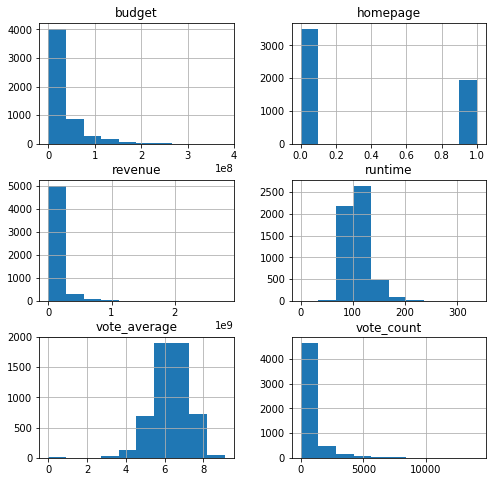

In [15]:
_ = movie_df.hist(figsize=(8,8))

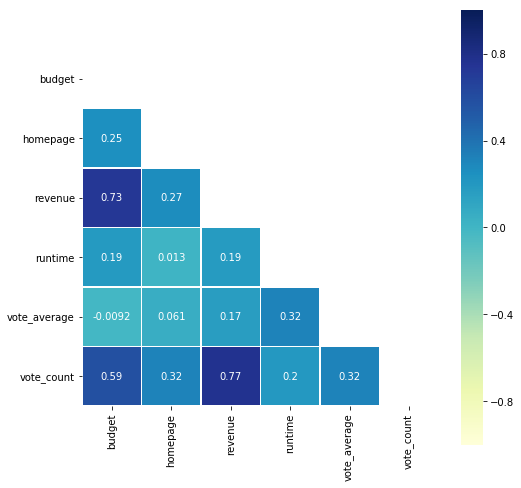

In [16]:
# A quick heatmap. It seems revenue and the number of votes are correlated.
corr = movie_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8, 8))
_ = sns.heatmap(corr, vmax=1, vmin=-1, mask=mask, square=True, annot=True, linewidths=0.2, center=0, cmap="YlGnBu")

In [46]:
# Toy Story Entry Example, looking it up by ID number
print(movie_df.loc[862])

belongs_to_collection                                 Toy Story Collection
budget                                                            30000000
genres                                         [Animation, Comedy, Family]
homepage                                                                 1
original_language                                                       en
overview                 Led by Woody, Andy's toys live happily in his ...
production_companies                             [Pixar Animation Studios]
production_countries                            [United States of America]
release_date                                                    10/30/1995
revenue                                                        3.73554e+08
runtime                                                                 81
spoken_languages                                                 [English]
tagline                                                                  0
title                    

In [18]:
def makeCSV(df, filename):
    df.to_csv(('./data/' + filename), index = True, sep=',', encoding='utf-8')

## Posters

In [19]:
# Modified from https://zeevgilovitz.com/detecting-dominant-colours-in-python
def compare(title, image, color_tuple):
    image = Image.new("RGB", (200, 200,), color_tuple)
    return image

def most_frequent_color(image):
    w, h = image.size
    pixels = image.getcolors(w * h)

    most_frequent_pixel = pixels[0]

    for count, color in pixels:
        if count > most_frequent_pixel[0]:
            most_frequent_pixel = (count, color)

    return most_frequent_pixel

def get_image(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return image

def get_most_freq_c(url):
    image = get_image(url)
    color = most_frequent_color(image)
    return color[1]

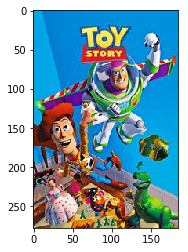

In [20]:
# Get Toy Story Poster Image
img = get_image(movie_df.loc[862, 'poster_path'])
imshow(img)

In [21]:
movie_df['most_freq_color'] = movie_df['poster_path'].apply(get_most_freq_c)

(1, 144, 222)


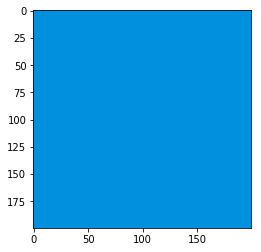

In [22]:
print(movie_df.loc[862, 'most_freq_color'])
image = Image.new("RGB", (200, 200,), movie_df.loc[862, 'most_freq_color'])
imshow(image)

In [23]:
# Take Color from tuple to individual RGB columns
temp = movie_df['most_freq_color'].apply(pd.Series)
#print(temp)
temp = temp.drop(3, axis=1)
movie_df = pd.concat([movie_df, temp], axis=1)
movie_df = movie_df.rename(columns = {0:'red'})
movie_df = movie_df.rename(columns = {1:'green'})
movie_df = movie_df.rename(columns = {2:'blue'})
movie_df = movie_df.drop('most_freq_color', axis=1)
movie_df['green'].fillna(0, inplace=True)
movie_df['blue'].fillna(0, inplace=True)
movie_df['red'] = movie_df['red'].astype(np.int64)
movie_df['green'] = movie_df['green'].astype(np.int64)
movie_df['blue'] = movie_df['blue'].astype(np.int64)

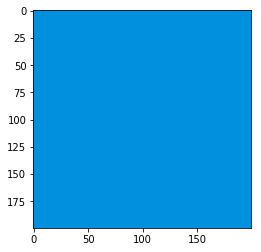

In [24]:
def get_color(movieid):
    color = tuple(movie_df.loc[movieid, 'red':'blue'])
    return color

def print_color(movieid):
    color = get_color(movieid)
    image = Image.new("RGB", (200, 200,), color)
    imshow(image)
    plt.show()
    return color

sample_color = print_color(862)
# Look at that, the conversion from tuple to column worked.

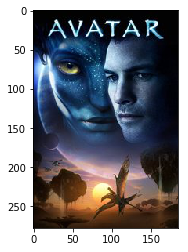

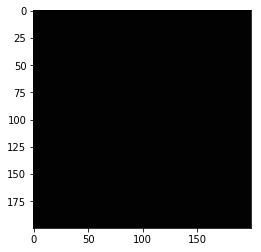

(2, 2, 2)


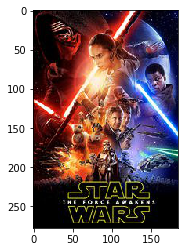

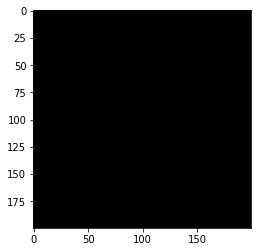

(0, 0, 0)


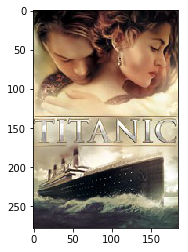

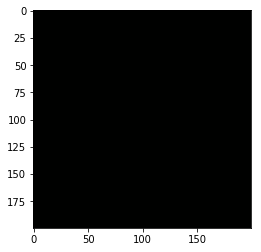

(0, 1, 0)


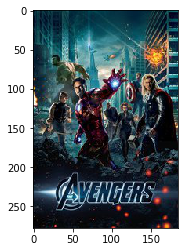

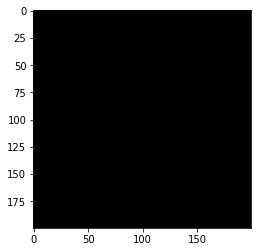

(0, 0, 0)


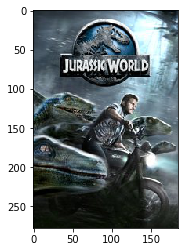

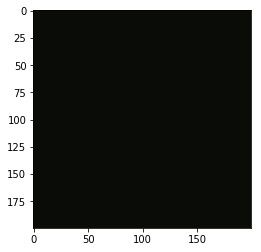

(10, 12, 7)


In [25]:
for index, row in movie_df.nlargest(5, 'revenue').iterrows():
    image = get_image(row['poster_path'])
    imshow(image)
    plt.show()
    color = print_color(index)
    print(color)

In [26]:
backup = movie_df

## Not Posters

In [29]:
# Function to truncate a list to the first 3 elements
def trunc_billing(cast):
    if len(cast) < 3:
        return cast
    else:
        return cast[0:3]
    
# Function to remove all duplicates from a list while retaining order.
def remove_dups(mylist):
    return sorted(set(mylist), key=lambda x: mylist.index(x))

def prep(mylist):
    mylist = remove_dups(mylist)
    return trunc_billing(mylist)

In [30]:
## Truncate the the top 3 billed actors and crew. Cast order matches Wikipedia, not sure what order it is though.
movie_df['cast'] = movie_df['cast'].apply(prep)
movie_df['crew'] = movie_df['crew'].apply(prep)

## Drop poster path
movie_df = movie_df.drop('poster_path', axis = 1)

In [48]:
## ONE HOT ENCODE GENRES ##
test = pd.get_dummies(movie_df['genres'].apply(pd.Series).stack()).sum(level=0)
dropping = []
for col in test.columns:
    if test[col].sum() < 2:
        dropping.append(col)
# Dropping TV movie from the list of genres, there's only one movie in here with it.
test = test.drop(dropping, axis=1)
print("New Features (Genres):", test.shape)

New Features (Genres): (5349, 19)


In [49]:
## MERGE TEST INTO MOVIE_DF
movie_df = pd.concat((movie_df, test), axis = 1)
movie_df = movie_df.drop('genres', axis = 1)
print(movie_df.shape)

(5443, 40)


In [70]:
## ONE HOT ENCODE SPOKEN LANGUAGES ##
## Option: Just add a 'English' column
test = pd.get_dummies(movie_df['spoken_languages'].apply(pd.Series).stack()).sum(level=0)
print(test.shape)
dropping = []
for col in test.columns:
    if test[col].sum() < 10:
        dropping.append(col)
test = test.drop(dropping, axis=1)
print("New Features (Spoken):", test.shape)
print(test.columns)

(5338, 63)
New Features (Spoken): (5338, 33)
Index(['', 'Dansk', 'Deutsch', 'English', 'Español', 'Français', 'Italiano',
       'Latin', 'Magyar', 'Nederlands', 'Norsk', 'Polski', 'Português',
       'Pусский', 'Română', 'Tiếng Việt', 'Türkçe', 'suomi', 'svenska',
       'Český', 'ελληνικά', 'Український', 'עִבְרִית', 'اردو', 'العربية',
       'हिन्दी', 'தமிழ்', 'తెలుగు', 'ภาษาไทย', '广州话 / 廣州話', '日本語', '普通话',
       '한국어/조선말'],
      dtype='object')


In [ ]:
## MERGE TEST INTO MOVIE_DF
#movie_df = pd.concat((movie_df, test), axis = 1)
#movie_df = movie_df.drop('spoken_languages', axis = 1)
#print(movie_df.shape)

In [54]:
## ONE HOT ENCODE PRODUCTION COUNTRIES ##
test = pd.get_dummies(movie_df['production_countries'].apply(pd.Series).stack()).sum(level=0)
print("New Features:", test.shape)
dropping = []
for col in test.columns:
    if test[col].sum() < 10:
        dropping.append(col)
test = test.drop(dropping, axis=1)
print("Remaining at the cutoff of 10 or more: ", test.shape)
print(test.columns)

New Features: (5301, 80)
Remaining at the cutoff of 10 or more:  (5301, 35)
Index(['Argentina', 'Australia', 'Austria', 'Belgium', 'Brazil', 'Canada',
       'China', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany',
       'Hong Kong', 'Hungary', 'India', 'Ireland', 'Italy', 'Japan',
       'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway',
       'Poland', 'Romania', 'Russia', 'South Africa', 'South Korea', 'Spain',
       'Sweden', 'Switzerland', 'Tunisia', 'United Arab Emirates',
       'United Kingdom', 'United States of America'],
      dtype='object')


In [53]:
## MERGE TEST INTO MOVIE_DF
#movie_df = pd.concat((movie_df, test), axis = 1)
#movie_df = movie_df.drop('production_countries', axis = 1)
#print(movie_df.shape)

In [58]:
## ONE HOT ENCODE PRODUCTION COMPANIES ##
test = pd.get_dummies(movie_df['production_companies'].apply(pd.Series).stack()).sum(level=0)
print("New Features:", test.shape)
dropping = []
for col in test.columns:
    if test[col].sum() < 10:
        dropping.append(col)
test = test.drop(dropping, axis=1)
print("Remaining at the cutoff of 10 or more: ", test.shape)
#print(list(set(test.columns) - set(dropping)))

New Features: (5185, 5431)
Remaining at the cutoff of 10 or more:  (5185, 230)


In [59]:
## MERGE TEST INTO MOVIE_DF
#movie_df = pd.concat((movie_df, test), axis = 1)
#movie_df = movie_df.drop('production_companies', axis = 1)
#print(movie_df.shape)

In [60]:
## ONE HOT ENCODE ACTORS ##
test = pd.get_dummies(movie_df['cast'].apply(pd.Series).stack()).sum(level=0)
print("New Features:", test.shape)
dropping = []
for col in test.columns:
    if test[col].sum() < 5:
        dropping.append(col)
# 6132 one-hot encoded actors.
# Drop it to those that have been in 5+ movies, bringing us to 789 one-hot encoded actors.
test = test.drop(dropping, axis=1)
print("One-hot encoded actors (5+ movies) by movie id:", test.shape)

New Features: (5350, 6132)
One-hot encoded actors (5+ movies) by movie id: (5350, 789)


In [61]:
## MERGE TEST INTO MOVIE_DF
#movie_df = pd.concat((movie_df, test), axis = 1)
#movie_df = movie_df.drop('cast', axis = 1)
#print(movie_df.shape)

In [62]:
movie_df.head(10).transpose()

id,5,11,12,13,14,15,16,18,19,22
belongs_to_collection,0,Star Wars Collection,Finding Nemo Collection,0,0,0,Heart of Gold Collection,0,0,Pirates of the Caribbean Collection
budget,4000000,11000000,94000000,55000000,15000000,839727,12800000,90000000,92620000,140000000
homepage,0,1,1,0,1,0,0,0,0,1
original_language,en,en,en,en,en,en,en,en,de,en
overview,It's Ted the Bellhop's first night on the job....,Princess Leia is captured and held hostage by ...,"Nemo, an adventurous young clownfish, is unexp...",A man with a low IQ has accomplished great thi...,"Lester Burnham, a depressed suburban father in...","Newspaper magnate, Charles Foster Kane is take...","Selma, a Czech immigrant on the verge of blind...","In 2257, a taxi driver is unintentionally give...",In a futuristic city sharply divided between t...,"Jack Sparrow, a freewheeling 17th-century pira..."
production_companies,"[Miramax Films, A Band Apart]","[Lucasfilm, Twentieth Century Fox Film Corpora...",[Pixar Animation Studios],[Paramount Pictures],"[DreamWorks SKG, Jinks/Cohen Company]","[RKO Radio Pictures, Mercury Productions]","[Fine Line Features, Zentropa Entertainments, ...","[Columbia Pictures, Gaumont]","[Paramount Pictures, Universum Film (UFA)]","[Walt Disney Pictures, Jerry Bruckheimer Films]"
production_countries,[United States of America],[United States of America],[United States of America],[United States of America],[United States of America],[United States of America],"[Argentina, Denmark, Finland, France, Germany,...",[France],[Germany],[United States of America]
release_date,12/9/1995,5/25/1977,5/30/2003,7/6/1994,9/15/1999,4/30/1941,5/17/2000,5/7/1997,1/10/1927,7/9/2003
revenue,4.3e+06,7.75398e+08,9.40336e+08,6.77945e+08,3.56297e+08,2.32177e+07,4.00319e+07,2.6392e+08,650422,6.55011e+08
runtime,98,121,100,142,122,119,140,126,153,143


In [63]:
makeCSV(movie_df, 'colors.csv')

## Initial Models  

I'm just going to put the modeling helper functions I made for the midterm here for now.

In [71]:
from sklearn.model_selection import train_test_split

revenue_df = movie_df['revenue']
df = movie_df.drop('revenue', axis=1)

train_df, test_data, revenue_df, test_revenue = train_test_split(df, revenue_df, test_size=None, random_state=42)
print("Train: ", train_df.shape)
print("Test: ", test_data.shape)

Train:  (4082, 39)
Test:  (1361, 39)


In [72]:
from sklearn.model_selection import GridSearchCV

def getCSV(prediction,filename):
    submission = pd.DataFrame({"id":revenue.index, "revenue":prediction})
    submission = submission[['id', 'revenue']]
    submission.to_csv(('./models/' + filename), index = False)

def getPred(model, params, filename):
    cv = GridSearchCV(model, params, scoring='roc_auc') #Scoring TBD
    cv.fit(train_df, revenue_df)
    print("in", filename, "best parameters:", cv.best_params_, "with score of", cv.best_score_)
    pred = cv.best_estimator_.predict(test_data)
    getCSV(pred, filename)

In [74]:
# After deciding what to do with the features, we essentially just make a ton of these with different models.
import xgboost as xgb

params = {
    'max_depth': [4],
    'learning_rate': [0.01],
    'n_estimators': [500],
}

getPred(xgb.XGBClassifier(), params, 'xgb_pred.csv')

C:\Users\chris\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields belongs_to_collection, original_language, overview, production_companies, production_countries, release_date, spoken_languages, tagline, title, keywords, cast, crew